In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import keras as ks
from keras.preprocessing import image
from keras.applications import imagenet_utils
from IPython.display import display
from PIL import Image
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, SGD
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from keras.layers.advanced_activations import LeakyReLU
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, roc_curve, auc)

%matplotlib inline

Using TensorFlow backend.


In [2]:
model = ks.applications.mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', pooling='avg')
#input shape : argumento, es por defecto esos valores
# include_top: si se incluye la capa totalmente conectada en la parte superior de la red.
# weights='imagenet' 
#Pesos: uno de None(inicialización aleatoria) o 'imagenet'(pre-entrenamiento en ImageNet).
# pooling (agrupacion) -> avg significa promedio global ... salida del modelo de dos dimensiones

#esto retom un modelo de keras

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:295: UserWarning: MobileNet shape is undefined. Weights for input shape(224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


Instructions for updating:
Colocations handled automatically by placer.


In [3]:
#f = carpeta del directorio
# l= label
# m= pesos -> modelo qe usamos para predecir
#Carga todas las imagenes de la carpeta que le indiaste y las procesa y le pone la etiqueta de sano y enfermo
def load_images_from_folder(f, l, m):
    e_l = []
    feat_l = []
    for filename in tqdm(os.listdir(f)): #TQDM es una biblioteca de barras de progreso con buen soporte para bucles anidados y notebooks Jupyter / IPython.
        img_path = os.path.join(f, filename) #directorio
        img = image.load_img(img_path, target_size=(224, 224)) #cargamos la imagen y le pasamos el tamanio
        x = image.img_to_array(img) #convierte a array 
        x = np.expand_dims(x, axis=0)#se expande la dimension del array... necesario para que pueda predecir
        x = preprocess_input(x) # La preprocess_inputfunción está diseñada para adecuar su imagen al formato que requiere el modelo.
        e = m.predict(x) #predecimos

        e_l.append(e) #aca mete la predicicion
        feat_l.append(l) #y aca mete label
        
    return e_l, feat_l

In [4]:
#Procesa una sola imagen
def load_image(f, m):
    img_path = os.path.join('', f)
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    e = m.predict(x)
        
    return e

In [5]:
enfermos, feat_enfermos = load_images_from_folder('fondo_de_ojo_train/enfermo/', 0,model)

100%|██████████| 828/828 [01:03<00:00, 14.05it/s]


In [6]:

sanos, feat_sanos = load_images_from_folder('fondo_de_ojo_train/sano/', 1, model)

100%|██████████| 817/817 [01:01<00:00, 13.61it/s]


In [8]:
#juntamos para entrenar la red
X = sanos + enfermos #JUNTAMOS SANOS Y ENFERMOS
Y = feat_sanos + feat_enfermos #
X = np.array(X)
Y = np.array(Y)
X,Y = shuffle(X, Y, random_state = 0) #mezclamos todos los datos

In [9]:
nX = []
for x in X:
    nX.append(x[0])

nX = np.array(nX)

In [10]:
train_X,test_X,train_Y,test_Y = train_test_split(nX,Y,test_size=0.2) #dividimos en 20% pra test (?)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (1316, 1280) (1316,)
Testing data shape :  (329, 1280) (329,)


In [11]:
#Normalizar
#train_X = train_X / 255.
#test_X = test_X / 255.
# scaler = StandardScaler();
# scaler.fit(train_X);
# #X_val = scaler.transform(X_val)

train_X.mean(), train_X.std()

# scaler= MinMaxScaler()
# scaler.fit(train_X)
# train_X = scaler.transform(train_X)
# test_X = scaler.transform(test_X)

(0.46232197, 0.7729246)

In [12]:
classes = np.unique(train_Y)
nClasses = len(classes)
nClasses

2

In [13]:
train_Y_one_hot = to_categorical(train_Y)#el categorical convierte a binario
test_Y_one_hot = to_categorical(test_Y)
 
# Display the change for category label using one-hot encoding
print('Original label:', train_Y[9])
print('After conversion to one-hot:', train_Y_one_hot[1])

Original label: 0
After conversion to one-hot: [1. 0.]


In [14]:
train_Y_one_hot

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [15]:
train_X, valid_X, train_Y, valid_Y = train_test_split(train_X, train_Y_one_hot, test_size=0.2)

In [16]:
train_X.shape

(1052, 1280)

In [17]:
INIT_LR = 1e-3
epochs = 50 #cantidad de ciclos # Un 'epoch' significa cuando el optimizador ya vio todos los ejemplos de entrenamiento al menos una vez.
batch_size = 64 # 'batch_size' regula cuantas muestras utiliza el optimizador para calcular el gradiente en cada iteracion.
exp_name = 'e23'#nombre del exprimento

# Construimos nuestro modelo
mobile = Sequential() #Las redes neuronales se definen en Keras como una secuencia de capas. 
mobile.add(Dense(20, input_dim=train_X.shape[1], activation='relu'))
mobile.add(Activation('relu'))
mobile.add(Dense(15))
mobile.add(Activation('relu'))


mobile.add(Dense(nClasses, activation='softmax'))

#Imprime una representación resumida de tu modelo.
optimizer=Adam(lr=0.001)

mobile.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
mobile.summary()

# mobile.compile(loss=ks.losses.categorical_crossentropy, optimizer=ks.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

experiment_path = os.path.join('experimento/' + exp_name)
if not os.path.exists(experiment_path):
    os.makedirs(experiment_path)


callbacks = [
    ModelCheckpoint(os.path.join(experiment_path, 'weights.{epoch:03d}-{val_loss:.2f} hdf5'),
                   monitor='val_loss',
                   save_best_only=False,
                   save_weights_only=False,),
    TensorBoard(log_dir=os.path.join(experiment_path, 'logs'))
]

print('\nTraining...')
h = mobile.fit(train_X, train_Y, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=
               (valid_X, valid_Y),callbacks=callbacks)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                25620     
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                315       
_________________________________________________________________
activation_2 (Activation)    (None, 15)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 32        
Total params: 25,967
Trainable params: 25,967
Non-trainable params: 0
_________________________________________________________________

Training...
Instructions for updating:
Use tf.cast instead.
Train on 1052 samples, validate on 264 samples
Epoch 1/50
1052/1052 [========

In [20]:
# Ahora cargamos los pesos de la mejor iteracion
trained_model = load_model('experimento/e23/weights.013-0.58 hdf5')

# De esta forma puedo obtener predicciones para nuevos datos con mi modelo
Y_pred = trained_model.predict(test_X)

# Evaluamos el modelo sobre el conjunto de testing
test_loss, test_acc = trained_model.evaluate(test_X, test_Y_one_hot)
print('Resultados en test:\n  Loss: {:.4f}\n  MAE: {:.4f}'.format(test_loss, test_acc))


329/329 [==============================] - 0s 747us/step
Resultados en test:
  Loss: 0.5277
  MAE: 0.7416


In [21]:
mobile_eval = mobile.evaluate(test_X, test_Y_one_hot, verbose=1)

print('Test loss:', mobile_eval[0])
print('Test accuracy:', mobile_eval[1])

329/329 [==============================] - 0s 30us/step
Test loss: 0.8212414559622304
Test accuracy: 0.6352583590249522


In [22]:
# calculate predictions
predictions = mobile.predict(test_X)
# round predictions
rounded = [round(x[0]) for x in predictions]
print(rounded)

[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0,

In [23]:
enfermito = load_image('fondo_de_ojo_train/enfermo/retinopatía.png', model)
sanito = load_image('fondo_de_ojo_train/sano/iStock-147659033.jpg', model)

In [24]:
n1 = enfermito
n2 = sanito
n = np.array([n1, n2])
n.shape

(2, 1, 1280)

In [25]:
pred = trained_model.predict(n1)
pred

array([[0.9664891 , 0.03351095]], dtype=float32)

In [26]:
# Obtengamos predicciones para el conjunto de test
model_predictions = mobile.predict(test_X)
y_pred = model_predictions[:, 0]  
y_pred2 = [i for i in np.argmax(model_predictions, axis=1)]
y_true = test_Y #[i for i in np.argmax(test_Y, axis=1)]
print('+ Un vistazo algunas predicciones y el valor esperado:')
print('  y_pred = {}'.format(y_pred[:20]))
print('  y_true = {}'.format(y_true[:20]))

+ Un vistazo algunas predicciones y el valor esperado:
  y_pred = [0.23548211 0.12313782 0.13056847 0.49488014 0.9997949  0.9841817
 0.14888911 0.19671635 0.79723597 0.41148514 0.01358742 0.00948487
 0.9878734  0.20121014 0.5884188  0.9834336  0.792919   0.747292
 0.46411717 0.8383003 ]
  y_true = [1 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0]


+ Accuracy en test: 0.6353

+ Confusion Matrix


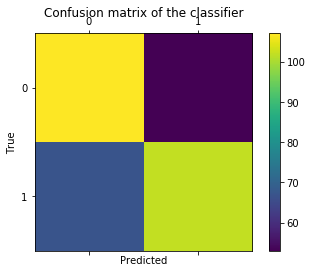


+ Classification Report
              precision    recall  f1-score   support

           0       0.61      0.67      0.64       160
           1       0.66      0.60      0.63       169

    accuracy                           0.64       329
   macro avg       0.64      0.64      0.64       329
weighted avg       0.64      0.64      0.64       329


+ ROC


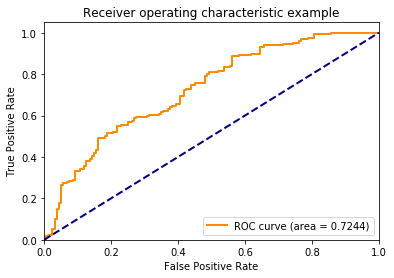

In [27]:
# Podemos usar accuracy_score en vez de model.evaluate para obtener
# el accuracy a partir de las predicciones y el valor esperado
acc = accuracy_score(y_true, y_pred2)
print('+ Accuracy en test: {:.4f}'.format(acc))

# Hagamos una matriz de confusion
# Mas info: https://en.wikipedia.org/wiki/Confusion_matrix
print('\n+ Confusion Matrix')
cm = confusion_matrix(y_true, y_pred2)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Tambien podemos usar el reporte de clasificacion
# Mas info: https://en.wikipedia.org/wiki/Precision_and_recall
print('\n+ Classification Report')
print(classification_report(y_true, y_pred2))

# Curva ROC
print('\n+ ROC')
y_pred_scores = model_predictions[:, 1]
fpr, tpr, thresholds = roc_curve(y_true, y_pred_scores)
roc_auc = auc(fpr, tpr)
# Plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc='lower right')
plt.show()

In [44]:
def load_images_from_folderr(f,m):
    e_l = []
    for filename in tqdm(os.listdir(f)): #TQDM es una biblioteca de barras de progreso con buen soporte para bucles anidados y notebooks Jupyter / IPython.
        img_path = os.path.join(f, filename) #directorio

        img = image.load_img(img_path, target_size=(224, 224)) #cargamos la imagen y le pasamos el tamanio
        x = image.img_to_array(img) #convierte a array 
        x = np.expand_dims(x, axis=0)#se expande la dimension del array... necesario para que pueda predecir
        x = preprocess_input(x) # La preprocess_inputfunción está diseñada para adecuar su imagen al formato que requiere el modelo.
        e = m.predict(x) #predecimos

        e_l.append((img_path, e)) #aca mete la predicicion
        #y aca mete label
        
    return e_l

In [45]:
path_img='fondo_de_ojo_test_unlabeled'
images = load_images_from_folderr(path_img,model)



100%|██████████| 816/816 [00:55<00:00, 14.71it/s]


In [46]:
import pandas as pd
X = [];
Y = [];
nombre = [];

for img in images:
    X.append(img[1][0])
    Y.append(img[0])
	
Xi = np.array(X)# feature de la imagen
Yi = np.array(Y)#nombre de la imagen

modelo_entrenado = load_model('experimento/e23/weights.013-0.58 hdf5')

m = modelo_entrenado.predict(Xi)

m_x = np.argmax(m, axis=1)
for i in m_x:
    if i == 0:
        nombre.append('enfermo')
    else:
        nombre.append('sano')
df = pd.DataFrame(data={'nombre':Yi,'clase':nombre}, columns = ['nombre','clase'])

    

df.to_csv("CSV/file.csv")


In [34]:
Xi.shape


(817, 1, 1280)